## **Import libraries**

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_column', 100)

## **Load dataset**

In [5]:
df = pd.read_csv('hyundai.csv')
df

,model,year,price,transmission,mileage,fuelType,tax(£),mpg,engineSize
0,I20,2017,7999,Manual,17307,Petrol,145,58.9,1.2
1,Tucson,2016,14499,Automatic,25233,Diesel,235,43.5,2.0
2,Tucson,2016,11399,Manual,37877,Diesel,30,61.7,1.7
3,I10,2016,6499,Manual,23789,Petrol,20,60.1,1.0
4,IX35,2015,10199,Manual,33177,Diesel,160,51.4,2.0
...,...,...,...,...,...,...,...,...,...
4855,I30,2016,8680,Manual,25906,Diesel,0,78.4,1.6
4856,I40,2015,7830,Manual,59508,Diesel,30,65.7,1.7
4857,I10,2017,6830,Manual,13810,Petrol,20,60.1,1.0
4858,Tucson,2018,13994,Manual,23313,Petrol,145,44.8,1.6


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         4860 non-null   object 
 1   year          4860 non-null   int64  
 2   price         4860 non-null   int64  
 3   transmission  4860 non-null   object 
 4   mileage       4860 non-null   int64  
 5   fuelType      4860 non-null   object 
 6   tax(£)        4860 non-null   int64  
 7   mpg           4860 non-null   float64
 8   engineSize    4860 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 341.8+ KB


In [7]:
# Rename the tax(£) column 
df.rename(columns={'tax(£)': 'tax'}, inplace=True)

In [8]:
# print a summary of the numerical Hyundai used car data
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,4860.000000,4860.00000,4860.000000,4860.000000,4860.000000,4860.000000
mean,2017.107613,12750.13107,21486.049588,121.147119,53.827798,1.457922
std,1.920456,5992.92231,17710.196964,58.003289,12.736042,0.400788
min,2000.000000,1200.00000,1.000000,0.000000,1.100000,0.000000
25%,2016.000000,8000.00000,8339.250000,125.000000,44.800000,1.200000
50%,2017.000000,11990.00000,17462.000000,145.000000,55.400000,1.600000
75%,2019.000000,15733.75000,30967.000000,145.000000,60.100000,1.700000
max,2020.000000,92000.00000,138000.000000,555.000000,256.800000,2.900000


In [9]:
cat_features = df.select_dtypes(include=[np.object]).columns
df[cat_features].describe()

,model,transmission,fuelType
count,4860,4860,4860
unique,16,4,4
top,Tucson,Manual,Petrol
freq,1300,3611,2902


In [10]:
for i in cat_features:
    print(f' {i}:', df[i].unique())
    print()

 model: [' I20' ' Tucson' ' I10' ' IX35' ' I30' ' I40' ' Ioniq' ' Kona'
 ' Veloster' ' I800' ' IX20' ' Santa Fe' ' Accent' ' Terracan' ' Getz'
 ' Amica']

 transmission: ['Manual' 'Automatic' 'Semi-Auto' 'Other']

 fuelType: ['Petrol' 'Diesel' 'Hybrid' 'Other']



In [11]:
num_features = df.select_dtypes(exclude=[np.object]).columns
df[num_features]

,year,price,mileage,tax,mpg,engineSize
0,2017,7999,17307,145,58.9,1.2
1,2016,14499,25233,235,43.5,2.0
2,2016,11399,37877,30,61.7,1.7
3,2016,6499,23789,20,60.1,1.0
4,2015,10199,33177,160,51.4,2.0
...,...,...,...,...,...,...
4855,2016,8680,25906,0,78.4,1.6
4856,2015,7830,59508,30,65.7,1.7
4857,2017,6830,13810,20,60.1,1.0
4858,2018,13994,23313,145,44.8,1.6


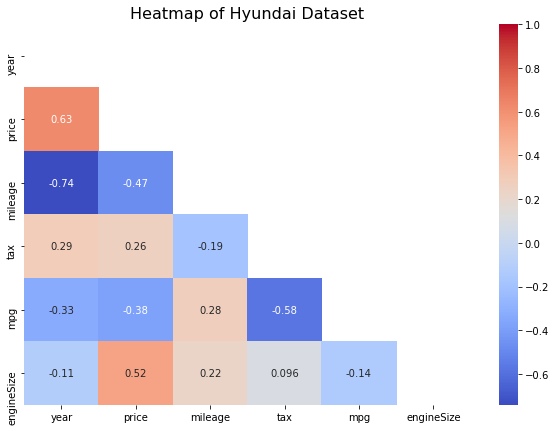

In [12]:
# Plot a heatmap to see correlation among numerical features
mask = np.zeros_like(df.corr()) 
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(10, 7))
plt.title('Heatmap of Hyundai Dataset', size=16)
sns.heatmap(df.corr(method='spearman'), cmap='coolwarm', annot=True, mask=mask, vmax=1);

year and mileage have a high correlation. Most likely will cause multicollinearity.

## **EDA**

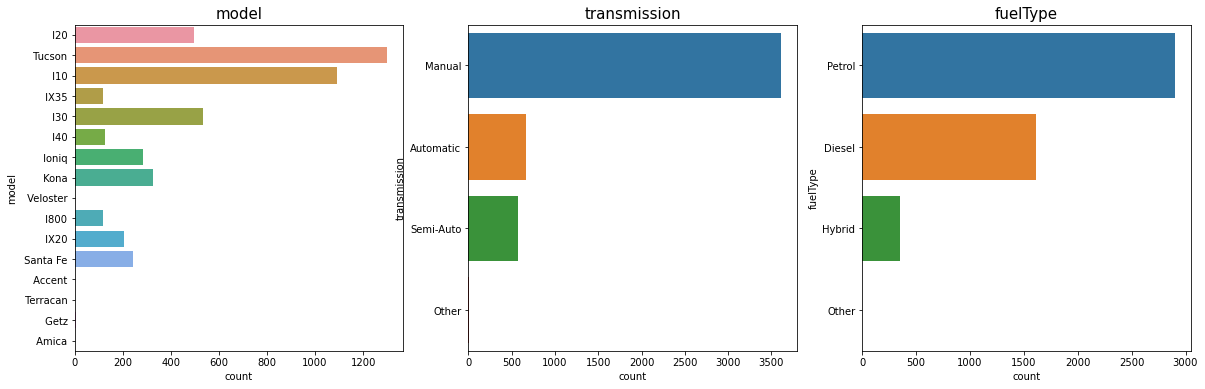

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, var in enumerate(cat_features):
    sns.countplot(y=var, data=df, ax=axes[i])
    axes[i].set_title(f'{var}', fontsize=15)

plt.show()

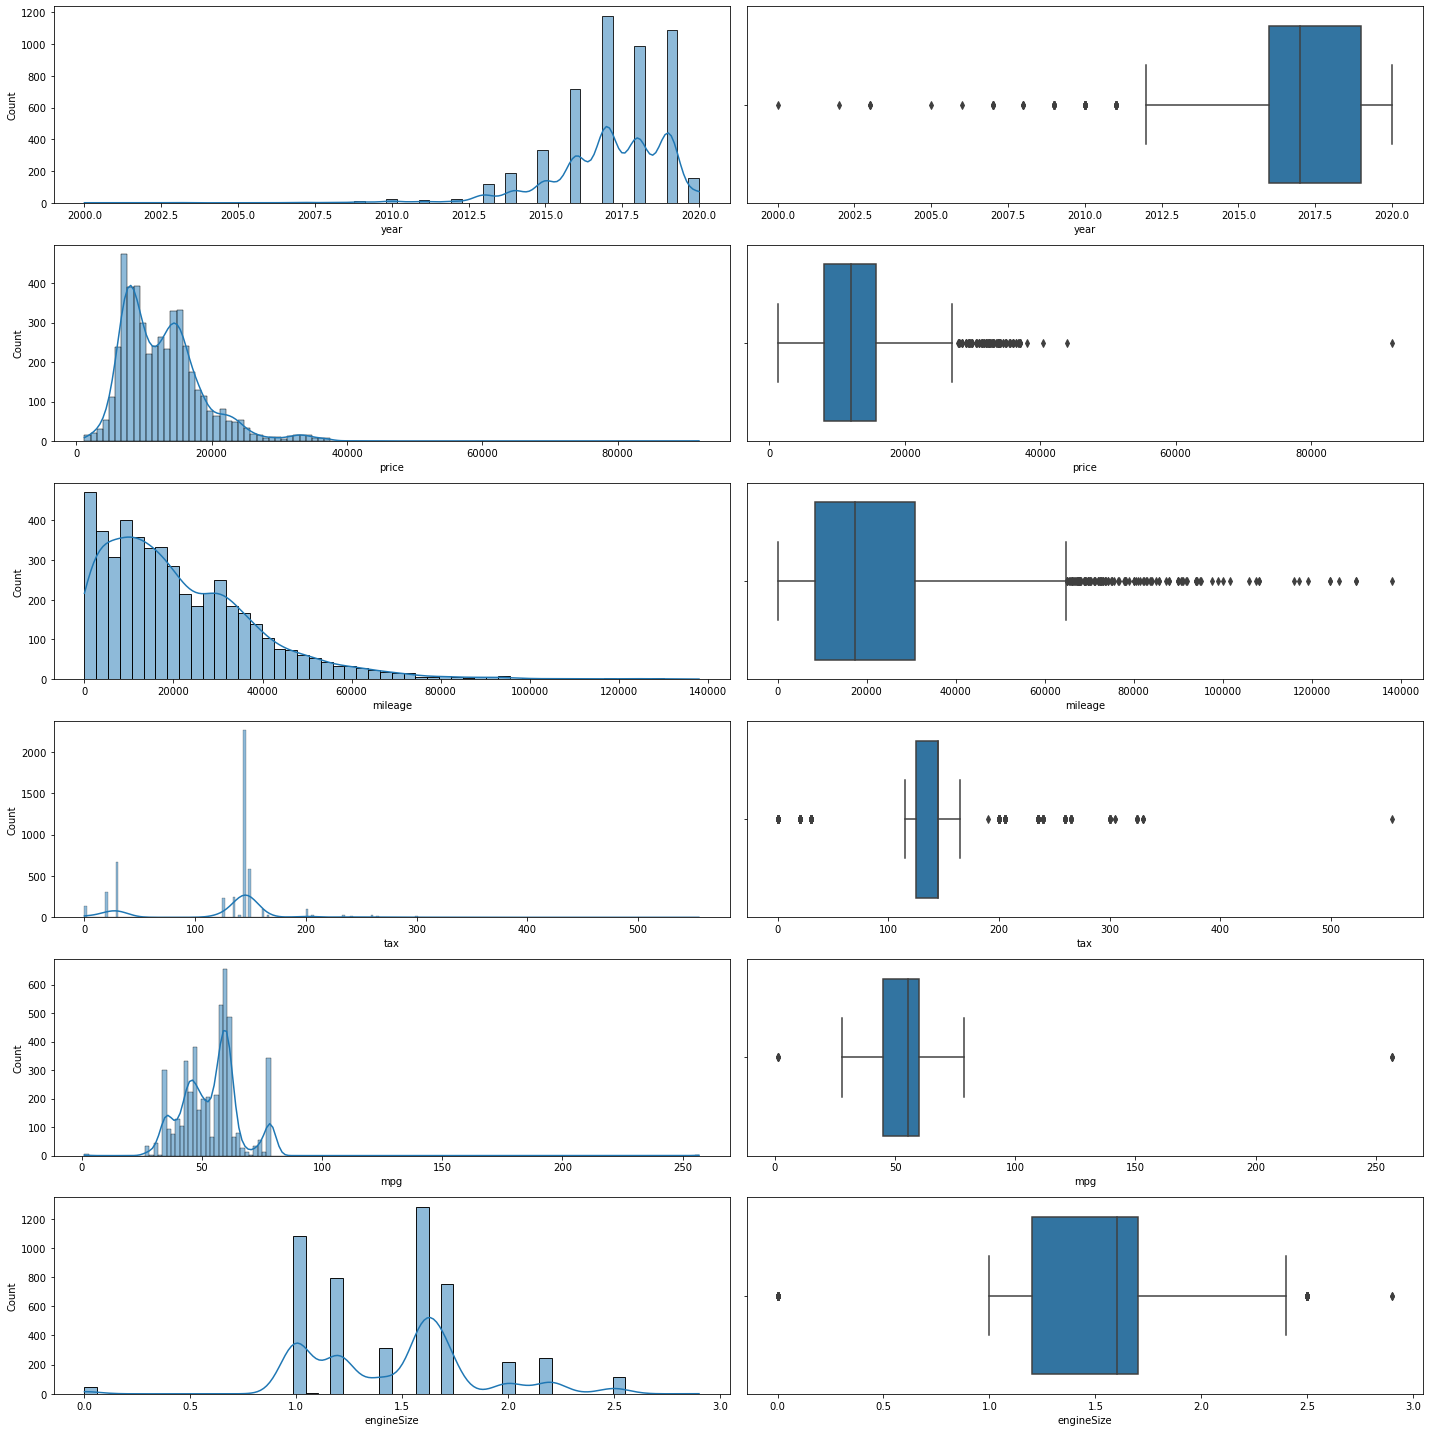

In [14]:
fig, axes = plt.subplots(6, 2, figsize=(20, 20))

for i, var in enumerate(num_features):
    sns.histplot(x=var, data=df, ax=axes[i, 0], kde=True)
    sns.boxplot(x=var, data=df, ax=axes[i, 1])

plt.tight_layout()
plt.show()

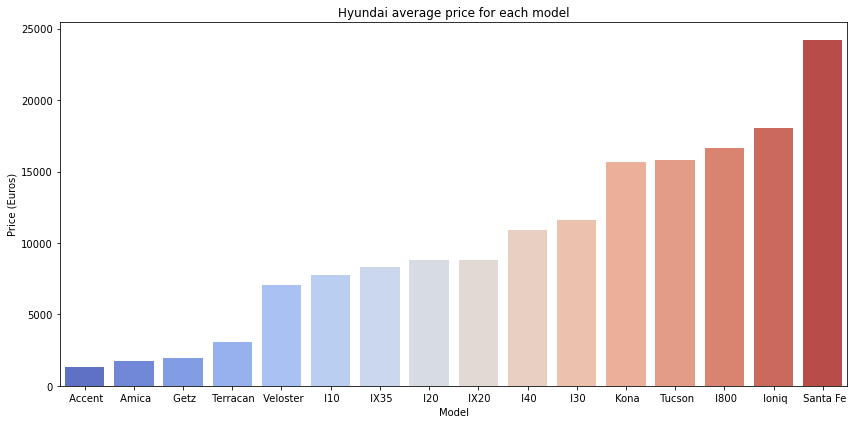

In [15]:
model_price = df.groupby('model')['price'].mean().sort_values()

plt.figure(figsize=(12, 6))
plt.title('Hyundai average price for each model')
pal = sns.color_palette('coolwarm', len(model_price))

sns.barplot(x=model_price.index, y=model_price.values, palette=pal)

plt.xlabel('Model')
plt.ylabel('Price (Euros)')
plt.tight_layout();

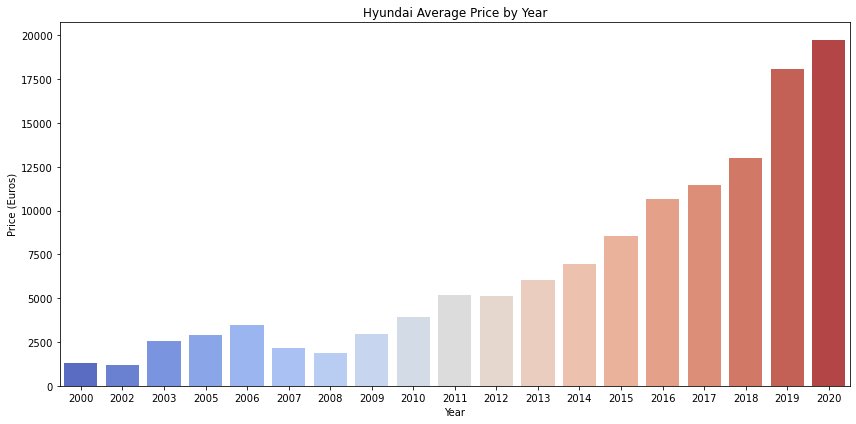

In [16]:
year_price = df.groupby('year')['price'].mean().sort_values()

plt.figure(figsize=(12, 6))
plt.title('Hyundai Average Price by Year')
pal = sns.color_palette('coolwarm', len(year_price))

sns.barplot(x=year_price.index, y=year_price.values, palette=pal)

plt.xlabel('Year')
plt.ylabel('Price (Euros)')
plt.tight_layout();

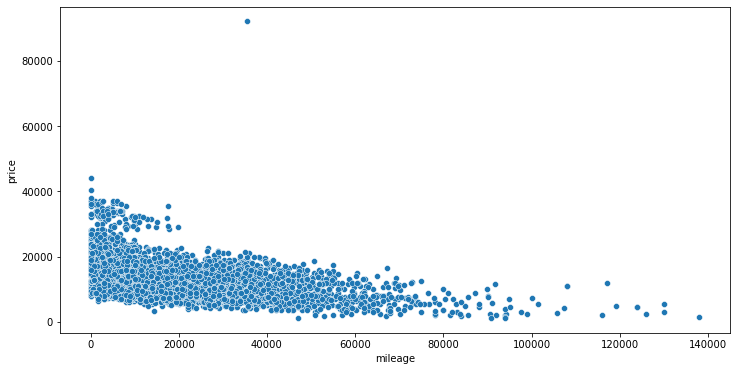

In [17]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df['mileage'], y=df['price']);

In [18]:
df[df['price'] > 40000]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
1985,Santa Fe,2020,43995,Semi-Auto,10,Diesel,145,39.2,2.2
2693,Santa Fe,2019,40365,Semi-Auto,1,Diesel,145,39.2,2.2
4247,I10,2017,92000,Automatic,35460,Petrol,150,47.9,1.2


The price of the 2017 I10 doesn't seem reasonable when compared to the price of a similar model which is in the 7000s range. Therefore, this data is considered as an outlier and can be dropped.

In [19]:
df[df['model'].str.contains('Santa Fe')]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
110,Santa Fe,2014,15500,Automatic,37006,Diesel,265,41.5,2.2
129,Santa Fe,2017,18999,Automatic,20599,Diesel,150,42.8,2.2
170,Santa Fe,2019,34998,Semi-Auto,4133,Diesel,145,39.2,2.2
171,Santa Fe,2019,34998,Semi-Auto,4956,Diesel,145,39.2,2.2
180,Santa Fe,2017,15998,Manual,48034,Diesel,205,47.1,2.2
...,...,...,...,...,...,...,...,...,...
4798,Santa Fe,2019,32995,Semi-Auto,3920,Diesel,145,39.2,2.2
4818,Santa Fe,2019,35995,Semi-Auto,6918,Diesel,145,39.2,2.2
4820,Santa Fe,2019,35985,Automatic,100,Diesel,145,39.2,2.2
4831,Santa Fe,2018,20985,Automatic,31123,Diesel,145,42.8,2.2


In [20]:
df[df['model'].str.contains('I10')]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
3,I10,2016,6499,Manual,23789,Petrol,20,60.1,1.0
5,I10,2015,6149,Manual,41650,Petrol,20,60.1,1.0
17,I10,2018,7100,Manual,35000,Petrol,145,60.1,1.0
18,I10,2016,7500,Manual,6000,Petrol,20,57.6,1.2
23,I10,2016,8100,Manual,7447,Petrol,30,57.6,1.2
...,...,...,...,...,...,...,...,...,...
4849,I10,2018,7500,Manual,13457,Petrol,145,60.1,1.0
4850,I10,2018,7200,Manual,17879,Petrol,145,60.1,1.0
4851,I10,2018,7995,Manual,8851,Petrol,145,60.1,1.0
4852,I10,2018,7200,Manual,14788,Petrol,150,60.1,1.0


In [21]:
df[df['tax'] > 300]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
229,I800,2017,15985,Automatic,35154,Diesel,325,33.6,2.5
533,I800,2016,14998,Automatic,17110,Diesel,325,33.6,2.5
783,I800,2016,13710,Automatic,27802,Diesel,325,33.6,2.5
1721,I800,2017,15499,Automatic,18000,Diesel,330,33.6,2.5
2194,IX35,2013,8471,Automatic,49180,Diesel,305,39.2,2.0
2386,I800,2016,12711,Automatic,48039,Diesel,325,33.6,2.5
3553,I800,2016,13110,Automatic,53292,Diesel,330,33.6,2.5
3980,I800,2016,12000,Automatic,55088,Diesel,330,33.6,2.5
4062,I800,2016,14300,Automatic,51446,Diesel,325,33.6,2.5
4311,Terracan,2005,2895,Manual,130000,Diesel,325,32.8,2.9


The old car tax can be more expensive because it is subject to a progressive tax for cars that are more than 10 years old, for example.

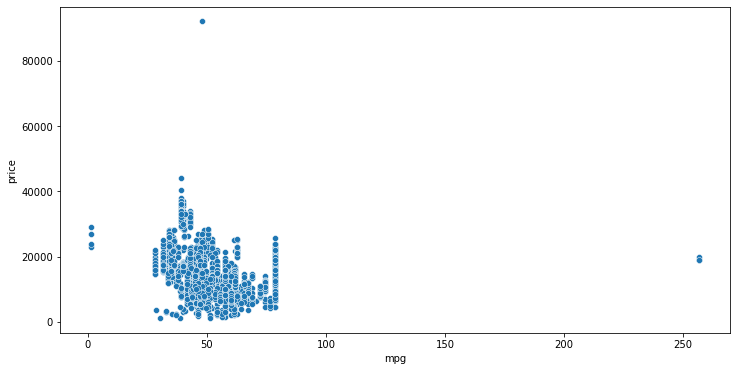

In [22]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df['mpg'], y=df['price']);

In [23]:
df[df['mpg'] > 250]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
1213,Ioniq,2018,18970,Automatic,14886,Hybrid,135,256.8,1.6
2088,Ioniq,2019,19995,Automatic,7386,Hybrid,135,256.8,1.6
2215,Ioniq,2018,18999,Automatic,12045,Hybrid,135,256.8,1.6


In [24]:
df[df['model'].str.contains('Ioniq')]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
30,Ioniq,2018,15000,Automatic,32227,Hybrid,135,78.5,1.6
74,Ioniq,2019,19800,Automatic,1963,Petrol,135,78.5,1.6
199,Ioniq,2019,20998,Automatic,5530,Hybrid,140,62.8,1.6
210,Ioniq,2019,22998,Automatic,2844,Hybrid,140,1.1,1.6
255,Ioniq,2018,17298,Automatic,19348,Hybrid,135,78.5,1.6
...,...,...,...,...,...,...,...,...,...
4791,Ioniq,2018,15998,Automatic,19054,Hybrid,135,78.5,1.6
4795,Ioniq,2017,15995,Automatic,18436,Hybrid,135,78.5,1.6
4806,Ioniq,2020,28995,Automatic,5213,Hybrid,135,1.1,1.6
4807,Ioniq,2019,18995,Automatic,4500,Hybrid,135,78.5,1.6


**1 mpg = 0.425144 kml**

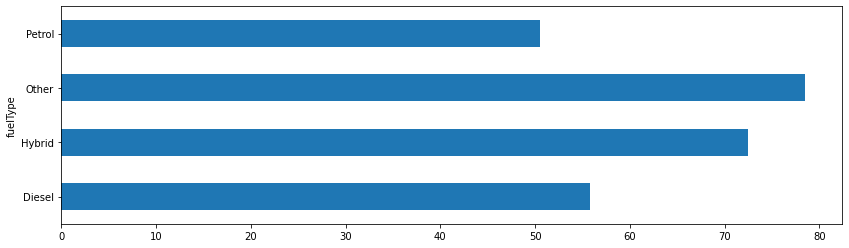

In [25]:
plt.figure(figsize=(14, 4))
df.groupby('fuelType')['mpg'].mean().plot.barh();

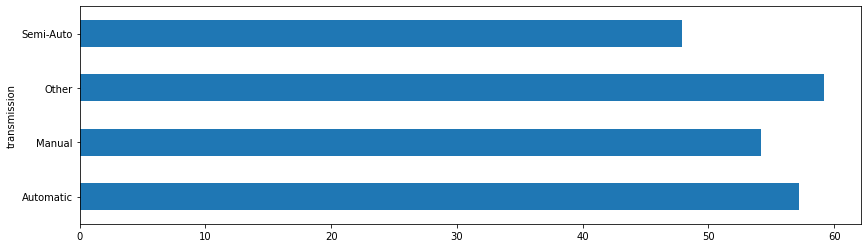

In [26]:
plt.figure(figsize=(14, 4))
df.groupby('transmission')['mpg'].mean().plot.barh();

In [27]:
df['transmission'].value_counts()

Manual       3611
Automatic     669
Semi-Auto     578
Other           2
Name: transmission, dtype: int64

In [28]:
df[df['transmission'].str.contains('Other')]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
4739,Ioniq,2017,12495,Other,27779,Hybrid,0,78.5,1.6
4761,Tucson,2017,16995,Other,25915,Petrol,145,39.8,1.6


In [29]:
df['fuelType'].value_counts()

Petrol    2902
Diesel    1608
Hybrid     349
Other        1
Name: fuelType, dtype: int64

In [30]:
df[df['fuelType'].str.contains('Other')]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
4673,Ioniq,2017,12800,Automatic,54698,Other,140,78.5,1.6


In [31]:
engine_0 = df[df['engineSize'] == 0.0]
engine_0

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
31,Tucson,2015,15200,Automatic,28904,Diesel,200,46.3,0.0
32,I10,2014,7700,Automatic,8646,Petrol,160,45.6,0.0
33,I30,2017,10500,Automatic,17663,Diesel,20,72.4,0.0
34,I20,2017,11400,Automatic,12661,Petrol,145,44.1,0.0
37,I10,2018,9000,Manual,7126,Petrol,145,60.1,0.0
39,I10,2018,8500,Manual,12948,Petrol,145,60.1,0.0
40,I30,2019,14500,Manual,2481,Petrol,145,41.5,0.0
41,Tucson,2016,13800,Manual,27311,Diesel,30,61.7,0.0
42,I30,2016,9000,Manual,34443,Diesel,0,78.4,0.0
43,Tucson,2017,13800,Manual,16961,Diesel,30,61.7,0.0


In [32]:
engine_0['model'].unique()

array([' Tucson', ' I10', ' I30', ' I20', ' I40', ' IX35', ' I800',
       ' IX20'], dtype=object)

In [33]:
models = ['Tucson', 'I10', 'I30', 'I20', 'I40', 'IX35', 'I800', 'IX20']

for i in models:
    print(f'{i}:', df[df['model'].str.contains(i)]['engineSize'].mean())

Tucson: 1.6734615384615212
I10: 1.0667582417582508
I30: 1.4720149253731363
I20: 1.1655241935483844
I40: 1.6692913385826738
IX35: 1.7279661016949137
I800: 2.4358974358974357
IX20: 1.4803921568627465


In [34]:
df.corr()['price']

year          0.575765
price         1.000000
mileage      -0.443576
tax           0.321028
mpg          -0.320355
engineSize    0.522384
Name: price, dtype: float64

## **Preprocessing**

In [35]:
# Drop rows that contain outliers
df = df.drop([4247, 4673, 4739, 4761], axis=0)
df.reset_index()

,index,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,0,I20,2017,7999,Manual,17307,Petrol,145,58.9,1.2
1,1,Tucson,2016,14499,Automatic,25233,Diesel,235,43.5,2.0
2,2,Tucson,2016,11399,Manual,37877,Diesel,30,61.7,1.7
3,3,I10,2016,6499,Manual,23789,Petrol,20,60.1,1.0
4,4,IX35,2015,10199,Manual,33177,Diesel,160,51.4,2.0
...,...,...,...,...,...,...,...,...,...,...
4851,4855,I30,2016,8680,Manual,25906,Diesel,0,78.4,1.6
4852,4856,I40,2015,7830,Manual,59508,Diesel,30,65.7,1.7
4853,4857,I10,2017,6830,Manual,13810,Petrol,20,60.1,1.0
4854,4858,Tucson,2018,13994,Manual,23313,Petrol,145,44.8,1.6


In [36]:
df.to_csv('hyundai_new.csv', index=False)

In [37]:
transformer = ColumnTransformer([
    ('One Hot', OneHotEncoder(drop='first'), ['transmission', 'fuelType']),
    ('Binary', ce.BinaryEncoder(), ['model'])
], remainder='passthrough')

## **Data splitting**

In [38]:
# Define X and y
X = df.drop(['price'], axis=1)
y = df['price']

### **Multicollinearity**

In [39]:
# Create a new variable for X, then fit and transform to calculate VIF
X_trans = pd.DataFrame(transformer.fit_transform(X))
X_trans.columns = transformer.get_feature_names()

In [40]:
# Function to calculate VIF
def calc_vif(x):
    vif = pd.DataFrame()
    vif['variables'] = x.columns
    vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    vif['Acceptable'] = np.where(vif.VIF < 4, 'Yes', 'No') 
    return (vif) 

In [41]:
X_trans.drop(['year', 'mpg', 'One Hot__x1_Hybrid', 'One Hot__x1_Petrol', 'engineSize'], axis=1, inplace=True)

In [42]:
calc_vif(X_trans)

,variables,VIF,Acceptable
0,One Hot__x0_Manual,3.962492,Yes
1,One Hot__x0_Semi-Auto,1.518791,Yes
2,Binary__model_0,1.003430,Yes
3,Binary__model_1,1.517440,Yes
4,Binary__model_2,1.784641,Yes
5,Binary__model_3,2.825147,Yes
6,Binary__model_4,2.207080,Yes
7,mileage,2.521429,Yes
8,tax,4.669882,No


## **Assumptions check**

### **Assumptions that must be met:**

1. **Linear relationship:** There is a linear relationship between the independent variable (X) and the dependent variable (y).

2. **Independence:** Residuals are independent or have no correlation with other residuals.

3. **Homoscedasticity:** Residuals have a constant variance.

4. **Normality:** Residuals of the model are normally distributed.

### **Linear relationship**

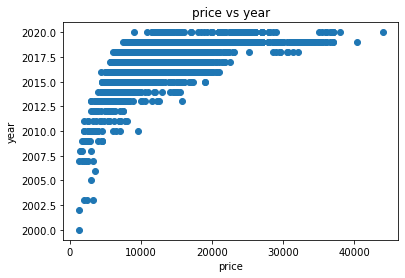

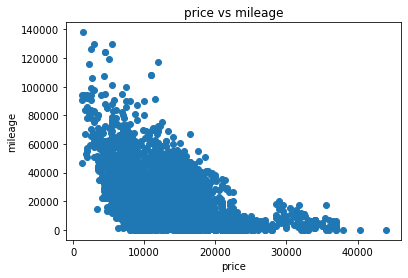

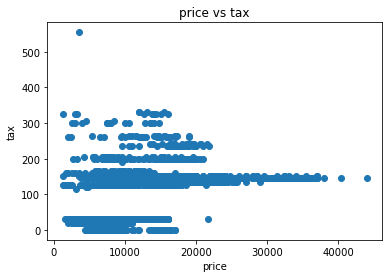

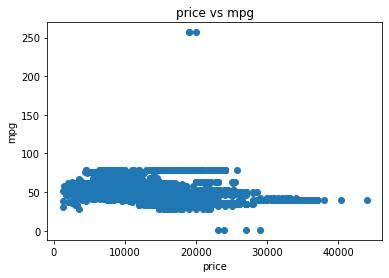

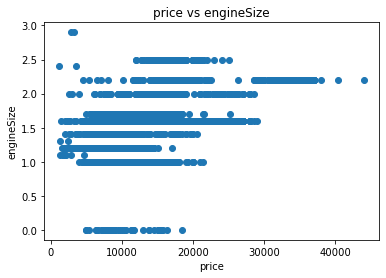

In [43]:
x_col = 'price'
y_columns = ['year', 'mileage', 'tax', 'mpg', 'engineSize']

for y_col in y_columns:
    figure = plt.figure
    ax = plt.gca()
    ax.scatter(df[x_col], df[y_col])
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title("{} vs {}".format(x_col, y_col))
    plt.show()

There is no linear relationship between the independent and target variables. This can be overcome by first transforming the data into logarithmic form, for example.

### **Normality**

**Create dummy variables**

In [44]:
df_dummy = pd.get_dummies(df, drop_first=True)
df_dummy.head()

,year,price,mileage,tax,mpg,engineSize,model_ Amica,model_ Getz,model_ I10,model_ I20,model_ I30,model_ I40,model_ I800,model_ IX20,model_ IX35,model_ Ioniq,model_ Kona,model_ Santa Fe,model_ Terracan,model_ Tucson,model_ Veloster,transmission_Manual,transmission_Semi-Auto,fuelType_Hybrid,fuelType_Petrol
0,2017,7999,17307,145,58.9,1.2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,2016,14499,25233,235,43.5,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2016,11399,37877,30,61.7,1.7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,2016,6499,23789,20,60.1,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,2015,10199,33177,160,51.4,2.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


**Scaling data for linear model**

In [45]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_dummy)
df_scaled = pd.DataFrame(df_scaled, columns=df_dummy.columns)

**Create an OLS model**

In [46]:
fitur_dummy = df_scaled.columns.drop('price')

In [47]:
fitur = fitur_dummy
target = 'price' 
sm_lm = sm.OLS(df_scaled[target], sm.add_constant(df_scaled[fitur]))
result = sm_lm.fit()

In [48]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     1483.
Date:                Mon, 01 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:09:51   Log-Likelihood:                -1733.1
No. Observations:                4856   AIC:                             3516.
Df Residuals:                    4831   BIC:                             3678.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.34

**Plot residuals**

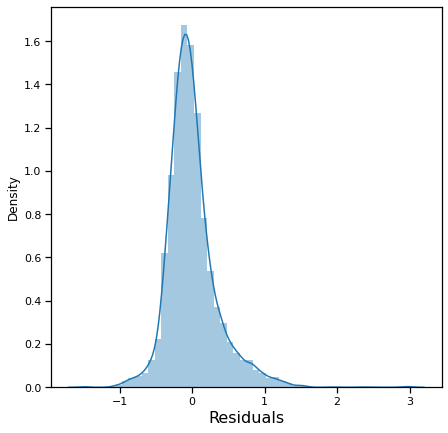

In [49]:
plt.figure(figsize=(7, 7))
sns.set_context('notebook', font_scale=1)
sns.distplot(result.resid)
plt.xlabel('Residuals', fontsize=16);

In [50]:
# Skewness check
result.resid.skew()

1.3512670008764482

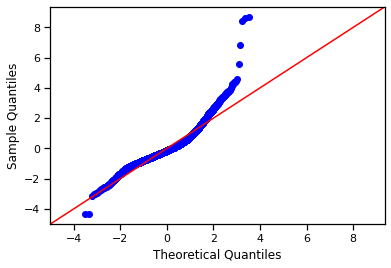

In [51]:
sm.qqplot(result.resid, line='45', fit=True);

Judging from the histogram and QQ-plot, it can be seen that the residuals do not follow the normal distribution. After being validated by looking at the magnitude of the skewness value, it turns out that it is true that the residual is skewed, in which the skewness value is 1.351 (including highly skewed).

### **Gauss-Markov (Independence, homoscedasticity)**

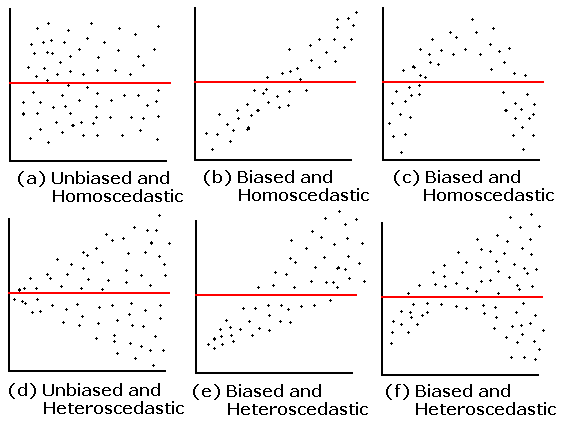

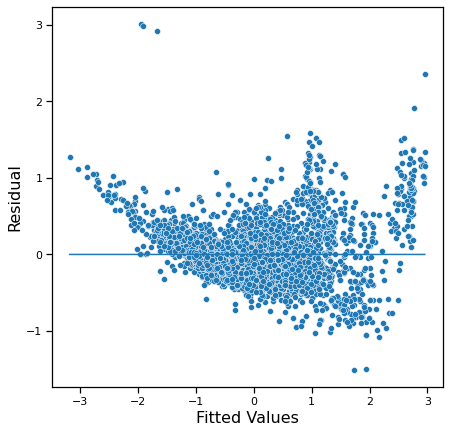

In [52]:
# Gauss-Markov plot
plt.figure(figsize=(7, 7))
sns.set_context('notebook', font_scale=1)
sns.scatterplot(result.fittedvalues, result.resid)
sns.lineplot(result.fittedvalues, 0)
plt.xlabel('Fitted Values', fontsize=16)
plt.ylabel('Residual', fontsize=16);

If it is matched between the examples of Gauss-Markov residuals and the results of the residual plot of the data worked on, it can be said that the residual plot above resembles a biased and heteroscedastic residual form. In other words, residuals are correlated with other residuals and also have heterogeneous variances.

### **Interpretation**

Because the assumptions of the linear model are not met, non-parametric regression models will be used for further modeling.

## **Non-parametric modeling**

### **Train-test splitting**

In [53]:
X_train, X_test, y_train, y_test= train_test_split(
    X,
    y,  
    test_size = 0.2,
    random_state = 1)

In [54]:
X_train_prep = pd.DataFrame(transformer.fit_transform(X_train))
X_test_prep = pd.DataFrame(transformer.transform(X_test))

X_train_prep.columns = transformer.get_feature_names()
X_test_prep.columns = transformer.get_feature_names()

### **Model benchmark**

In [55]:
# Define models
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=1)
rf = RandomForestRegressor(random_state=1)
xgb = XGBRegressor()

models = [knn, dt, rf, xgb]
score = []
nilai_mean = []
nilai_std = []

for i in models:
    crossval = KFold(n_splits=5)
    estimator = Pipeline([
    ('model', i)
])

    model_cv = cross_val_score(estimator, X_train_prep, y_train, cv=crossval, scoring='neg_root_mean_squared_error', error_score='raise')
    score.append(model_cv)
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

In [56]:
pd.DataFrame({
    'model':['knn', 'dt', 'rf', 'xgb'],
    'mean':nilai_mean,
    'std':nilai_std
})

,model,mean,std
0,knn,-5156.576438,159.276286
1,dt,-1565.338233,29.786257
2,rf,-1254.457028,44.481355
3,xgb,-1215.231092,36.554036


## **Model Performance on Test Set**

In [57]:
models={
    'XGB': XGBRegressor(),
    'RandomForest': RandomForestRegressor(random_state=1)
}

score=[]

for i in models:
    models[i].fit(X_train_prep, y_train)
    y_pred=models[i].predict(X_test_prep)
    score.append([mean_squared_error(y_test, y_pred)])
    score_root = np.sqrt(score)

score_before_tuning = pd.DataFrame(score_root, columns=['RMSE'], index = models.keys())
score_before_tuning

,RMSE
XGB,1249.880828
RandomForest,1390.535332


## **Tuning the model benchmark**

In [58]:
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [59]:
# Hyperparameter space XGBRegressor
hyperparam_space_xgb = [
    {'reg__learning_rate':[0.2], 'reg__n_estimators':[50], 'reg__max_depth':[3, 4, 5]},
    {'reg__learning_rate':[0.1], 'reg__n_estimators':[100], 'reg__max_depth':[3, 4, 5]},
    {'reg__learning_rate':[0.05], 'reg__n_estimators':[500], 'reg__max_depth':[3, 4, 5]},
    {'reg__learning_rate':[0.01], 'reg__n_estimators':[1000], 'reg__max_depth':[3, 4, 5]},
    {'reg__learning_rate':[0.005], 'reg__n_estimators':[5000], 'reg__max_depth':[3, 4, 5]}
]

In [60]:
# Create the algorithm chains
estimator_xgb = Pipeline([('reg', xgb)])

# Cross validation
kf = KFold(n_splits = 5, shuffle=True, random_state=1)

# Hyperparameter tuning
grid_xgb = GridSearchCV(
    estimator_xgb, 
    param_grid = hyperparam_space_xgb, 
    cv = kf, 
    scoring = 'neg_root_mean_squared_error', 
    n_jobs = -1 
)

In [61]:
grid_xgb.fit(X_train_prep, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('reg',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     enable_categorical=False,
                                                     gamma=None, gpu_id=None,
                                                     importance_type=None,
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_dep

In [62]:
print('XGBRegressor')
print('Best_score:', grid_xgb.best_score_)
print('Best_params:', grid_xgb.best_params_)

XGBRegressor
Best_score: -1163.6977476137702
Best_params: {'reg__learning_rate': 0.005, 'reg__max_depth': 5, 'reg__n_estimators': 5000}


## **Use the best estimator to predict test set**

In [63]:
xgb_tuning = grid_xgb.best_estimator_
xgb_tuning.fit(X_train_prep, y_train)

y_pred_xgb_tuning = xgb_tuning.predict(X_test_prep)
mse_xgb_tuning = mean_squared_error(y_test, y_pred_xgb_tuning)
rmse_xgb = np.sqrt(mse_xgb_tuning)

In [64]:
score_list = [rmse_xgb]
models = ['XGB']
score_after_tuning = pd.DataFrame({
    'Model': models,
    'RMSE': score_list
})

## **Comparison**

In [65]:
score_before_tuning

,RMSE
XGB,1249.880828
RandomForest,1390.535332


In [66]:
score_after_tuning

,Model,RMSE
0,XGB,1175.945111


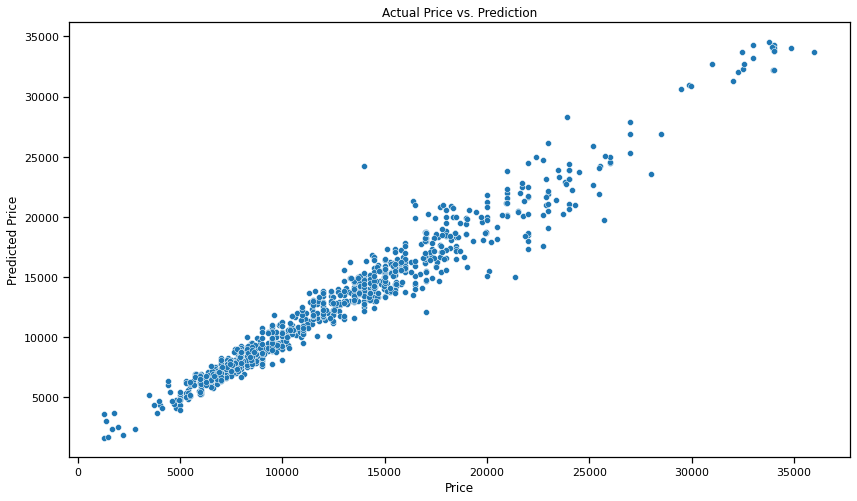

In [67]:
plt.figure(figsize=(14, 8))
plot = sns.scatterplot(x=y_test, y=y_pred_xgb_tuning).set(title='Actual Price vs. Prediction', 
                                               xlabel='Price', 
                                               ylabel='Predicted Price');

### **Interpretation**

By using a non-parametric model, in this case XGBRegressor is the most optimal, we can get pretty good results with an RMSE value of around 1175. This means, the average prediction of the model could be around +-1175 Euros. Of course there are still many ways that can be done to be able to improvise the output model so that it can produce a smaller error value, such as filling in the engineSize value of 0.0, performing feature selection, using other hyperparameters when tuning, etc.

## **Save model**

**Pickle**

In [68]:
# Save model
import pickle

estimator = Pipeline([('preprocess', transformer), ('model', XGBRegressor())])
estimator.fit(X_train, y_train)

pickle.dump(estimator, open('Final_Model_XGB.sav', 'wb'))

In [69]:
# Load model
filename = 'Final_Model_XGB.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [70]:
np.sqrt(mean_squared_error(y_test, loaded_model.predict(X_test)))

1249.8808283758885

## **Model training**

In [71]:
hyundai_train = df[:972]
hyundai_test = df[972:]

hyundai_train.to_csv('hyundai_train.csv', index=False)
hyundai_test.to_csv('hyundai_test.csv', index=False)

In [72]:
# Basic operations
import pandas as pd
import numpy as np

# ML model
from sklearn.ensemble import RandomForestRegressor

# Feature engineering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Model
import pickle
import joblib

# Data
df = pd.read_csv('hyundai_new.csv')

# Preprocess
transformer = ColumnTransformer([
                                ('One Hot', OneHotEncoder(drop='first'), ['transmission', 'fuelType']),
                                ('Binary', ce.BinaryEncoder(), ['model'])
                                ], remainder='passthrough')

# Data splitting
X = df.drop(columns='price', axis=1)
y = df['price']

# Model selection
model = XGBRegressor()

estimator = Pipeline([
                      ('preprocess', transformer),
                      ('reg', model)
])

hyperparam_space = [
    {'reg__learning_rate':[0.2], 'reg__n_estimators':[50], 'reg__max_depth':[3, 4, 5]},
    {'reg__learning_rate':[0.1], 'reg__n_estimators':[100], 'reg__max_depth':[3, 4, 5]},
    {'reg__learning_rate':[0.05], 'reg__n_estimators':[500], 'reg__max_depth':[3, 4, 5]},
    {'reg__learning_rate':[0.01], 'reg__n_estimators':[1000], 'reg__max_depth':[3, 4, 5]},
    {'reg__learning_rate':[0.005], 'reg__n_estimators':[5000], 'reg__max_depth':[3, 4, 5]}
]

crossval = KFold(n_splits = 5, shuffle=True, random_state=1)

grid_search = GridSearchCV(
    estimator, 
    param_grid = hyperparam_space, 
    cv = crossval,
    scoring = 'neg_root_mean_squared_error', 
    n_jobs = -1
)

grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('One '
                                                                         'Hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['transmission',
                                                                          'fuelType']),
                                                                        ('Binary',
                                                                         BinaryEncoder(),
                                                                         ['model'])])),
                                       ('reg',
                                        XGBRegress

In [73]:
# Model Pickling
grid_search.best_estimator_.fit(X, y)
filename = 'Model_XGB.sav'
pickle.dump(grid_search.best_estimator_, open(filename, 'wb'))

# Load dataset
df = pd.read_csv('hyundai_new.csv')

# Load model
filename = 'Model_XGB.sav'
loaded_model = pickle.load(open(filename, 'rb'))

### **Predict an observation**

In [74]:
df_predict = pd.DataFrame({
    'model':[' Tucson'],
    'year':[2019],
    'transmission':['Automatic'],
    'mileage':[14000],
    'fuelType':['Petrol'],
    'tax':[150],
    'mpg':[37],
    'engineSize':[1.6]
})

print('predicted price:', loaded_model.predict(df_predict))

predicted price: [17869.318]


In [75]:
df[(df['model'] == ' Tucson') & (df['year'] == 2019)]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
13,Tucson,2019,17750,Manual,10000,Petrol,150,34.9,1.6
36,Tucson,2019,18000,Manual,4353,Petrol,145,35.3,1.6
62,Tucson,2019,15000,Manual,22397,Petrol,150,34.9,0.0
63,Tucson,2019,16300,Manual,10066,Petrol,150,34.9,0.0
106,Tucson,2019,15600,Manual,8000,Petrol,150,34.9,1.6
...,...,...,...,...,...,...,...,...,...
4356,Tucson,2019,16999,Automatic,13797,Petrol,145,36.2,1.6
4386,Tucson,2019,15499,Manual,9841,Petrol,145,34.9,1.6
4733,Tucson,2019,17499,Automatic,10169,Petrol,150,36.2,1.6
4734,Tucson,2019,14999,Manual,11229,Petrol,150,34.9,1.6
